# Principal Component Analysis (PCA) for MD simulations

[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a relatively simply and yet a very powerful technique that can be used for exploratory analysis of your data. Typically it is used for preparing the data for advanced treatment such as segmentation or classfication. It's chief utility is for reducing the complexity of the data detecting highly associated ("Collective") behavior in the data.

PCA works by [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) of the [Covariance matrix](https://en.wikipedia.org/wiki/Covariance_matrix) into orthogonal components. These components are uncorrelated by the virtue of being orthogonal eigenvectors of the covariance matrix. PCA is a [linear](https://en.wikipedia.org/wiki/Linear_map) technique as the original data can be expressed as a direct weighted sum of the eigenvectors. The corresponding eigenvalues of the decompoisition are a measure of the [variance](https://en.wikipedia.org/wiki/Variance) contained in each component. Technically, PCA does not directly provide [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) as the number of eigenvectors is equal to the number of input variables. However, by restricting analysis to eigenvectors with eigenvalues it is possible to model the remaining eigenvectors as noise. The reduced space obtained by taking these few eigenvectors is thus used for dimensionality reduction and these vectors are called Pricipal Components. 

In this tutorial you will learn:

    1. How to perform PCA with simple numpy functions?
    2. How to use PCA for segmentation of a high dimensional dataset (IRIS dataset)?
    3. How to use PCA to detect collective modes in MD simulation data?

Let's start by first building a simple example to demonstrate how PCA works.

In [1]:
# imports

# generic tools
import numpy as np
import seaborn as sns # we will use seaborn for fancy plots such as pairplots.
import pandas as pd # we need pandas to use some seaborn functionality
import pylab as plt # standard plottign library
import math # standard mathematical library

# tools for MD simulation trajectory analysis
import MDAnalysis as mda # for analysing MD data
import nglview as nv # for visualizing MD data

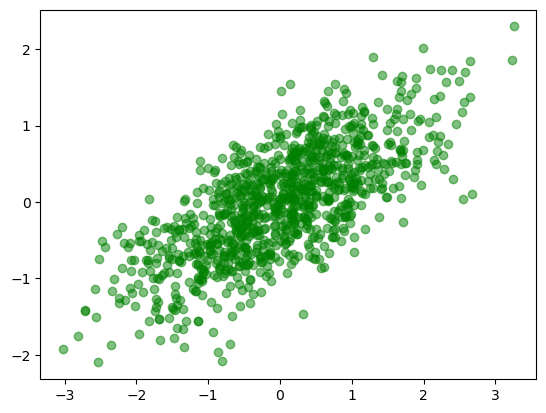

In [2]:
# Generate some correlated data
n_points = 1000
n_dims = 2
data = np.random.randn(n_points, n_dims)
data[:, 1] = 0.5*data[:, 0] + 0.5 * np.random.randn(n_points)
# visualize the data
plt.scatter(data[:,0],data[:,1],color = 'g', alpha = 0.5)

In [3]:
# Center the data
# This step removes the mean from the data and puts it at the origin
data -= np.mean(data, axis=0)

In [4]:
# Compute the covariance matrix
cov = np.cov(data.T)

In [5]:
# Compute the eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov)

In [6]:
# Sort the eigenvalues in descending order
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

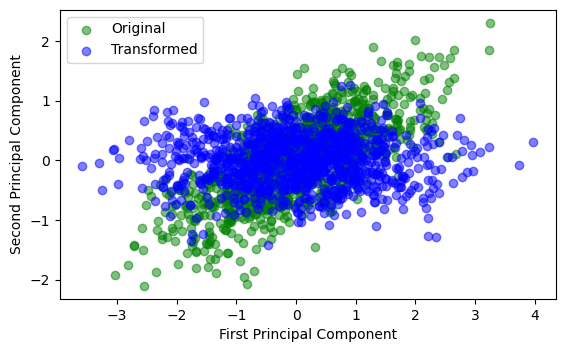

In [7]:
# Project the data onto the first two principal components
pca_data = np.dot(data, eig_vecs)

# Plot the projected data
plt.scatter(data[:,0],data[:,1],color = 'g', alpha = 0.5, label = 'Original')
plt.scatter(pca_data[:, 0], pca_data[:, 1],color = 'b', alpha = 0.5, label = 'Transformed')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.gca().set_aspect('equal')

**Question:** What has happened to the data due to PCA transformation?

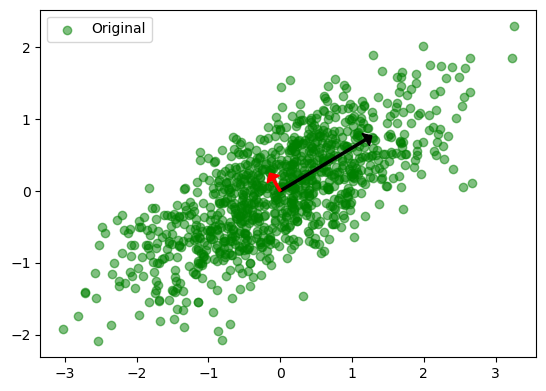

In [8]:
# Project the data onto the first two principal components
pca_data = np.dot(data, eig_vecs)

# Plot the projected data
plt.scatter(data[:,0],data[:,1],color = 'g', alpha = 0.5, label = 'Original')

# Plot the first two principal components as vectors
colors = ['k','r']
for i, scale in enumerate(eig_vals):
    plt.arrow(0, 0, scale * eig_vecs[0, i], scale * eig_vecs[1, i],\
              head_width=0.2, head_length=0.1, fc=colors[i], ec=colors[i],width = 0.03)

# Set the aspect ratio of the axes to 'equal'
plt.gca().set_aspect('equal')
plt.legend()

**Question:** Where are the arrows pointing? Why is the second (Red) arrow shorter?

**Question:** Are the two components orthogonal? How would you check that? HINT: np.dot()

### EXTRA:
#### Check if the components are orthogonal.

???

Let's now create some more complex dataset with more than two dimensions. We will create a 4D dataset and make the first and the second component correlated. We will also make the third and the fourth component anti-correlated.

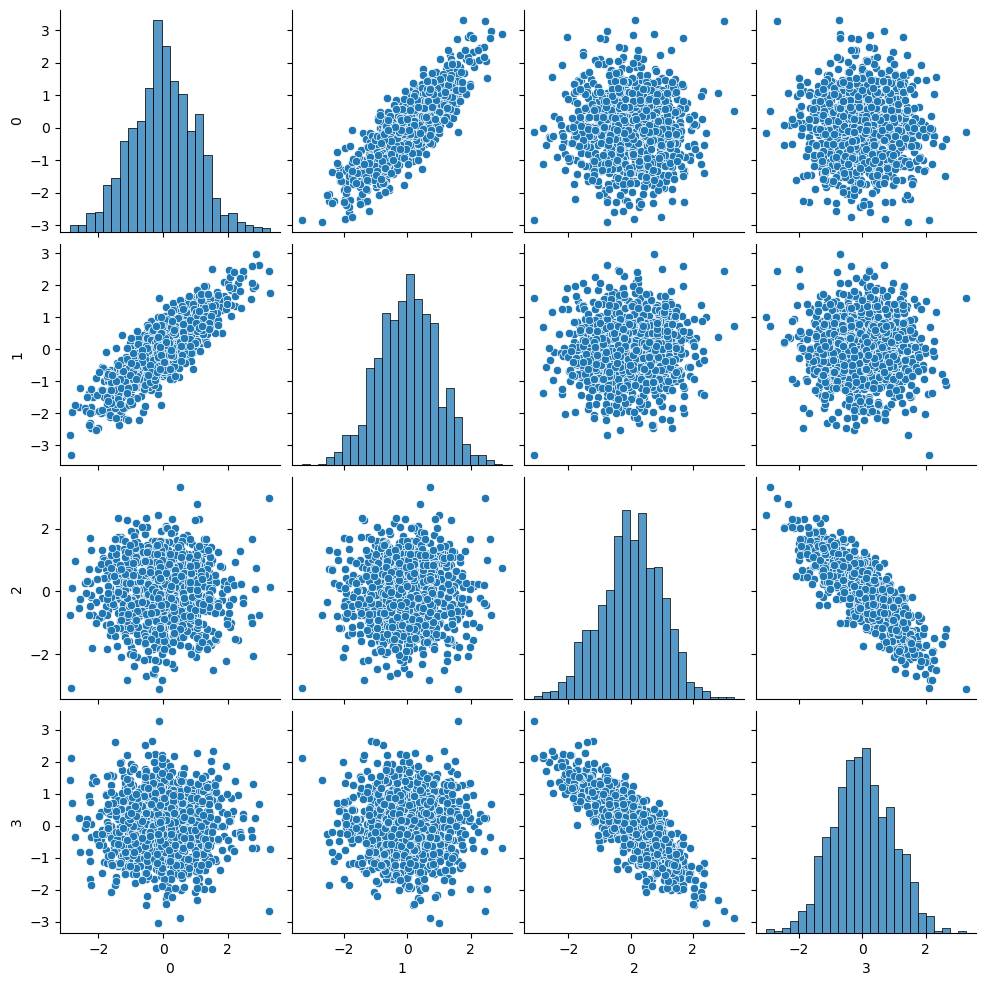

In [9]:
# Generate some correlated data

n_dims = 4
data = np.random.randn(n_points, n_dims)
data[:, 1] = 0.8*data[:, 0] + 0.5 * np.random.randn(n_points)
data[:, 3] = -0.8*data[:, 2] + 0.5 * np.random.randn(n_points)

# Center the data
data -= np.mean(data, axis=0)

# plot the data
axes = sns.pairplot(pd.DataFrame(data))

**Question**: do you see the correlation? Does it make sense? Given that the first and the second components are correlated and the third and the fourth components are correlated, what is the relation between the first and the third component?

Now we will perform PCA on this data set.

In [10]:
# Compute the covariance matrix
cov = np.cov(data.T)

# Compute the eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(cov)

# Sort the eigenvalues in descending order
idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

# Project the data onto the first two principal components
pca_data = np.dot(data, eig_vecs[:, :2])

Now let's look at the (sorted) Eigenvalue spectrum for the data.

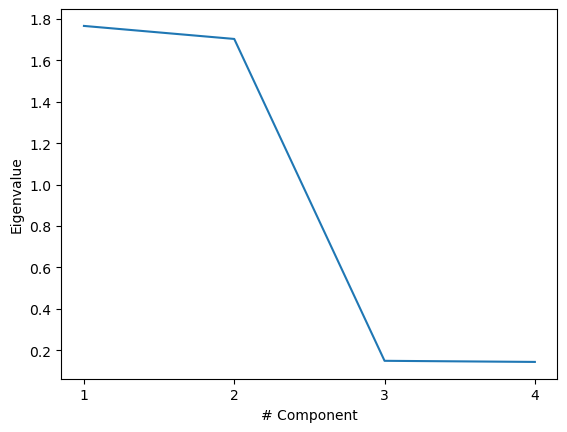

In [11]:
plt.plot(range(1,n_dims+1),eig_vals)
plt.xlabel('# Component')
plt.ylabel("Eigenvalue")
plt.xticks(range(1,5));

**Question:** What does the eigenvalue spectrum tell us?

**Question:** Recreate the data with 6 components as shown above. Make the first two components correlated to each other. How many "dominant" i.e. large eigenvalues do you expect to see? Check your infernece by plotting the eigenvalue spectrum.

Let's now compile our knowledge into a single PCA function and we have all the tools we need.

In [12]:
# write the PCA function
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced, sorted_eigenvalue, sorted_eigenvectors

We will use this function to perform all the PCA related tasks in the next part of the tutorial.

We are going to look at some real life datasets. A typical example is the [IRIS](https://en.wikipedia.org/wiki/Iris_flower_data_set) dataset. This data set has been historically used for statistical learning models to connect members of the Iris family of flowers to their physical characters such as Sepal and Petal lengths and widths.

In [13]:
#Get the IRIS dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
data = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [14]:
data

sepal length  sepal width  petal length  petal width          target
0             5.1          3.5           1.4          0.2     Iris-setosa
1             4.9          3.0           1.4          0.2     Iris-setosa
2             4.7          3.2           1.3          0.2     Iris-setosa
3             4.6          3.1           1.5          0.2     Iris-setosa
4             5.0          3.6           1.4          0.2     Iris-setosa
..            ...          ...           ...          ...             ...
145           6.7          3.0           5.2          2.3  Iris-virginica
146           6.3          2.5           5.0          1.9  Iris-virginica
147           6.5          3.0           5.2          2.0  Iris-virginica
148           6.2          3.4           5.4          2.3  Iris-virginica
149           5.9          3.0           5.1          1.8  Iris-virginica

[150 rows x 5 columns]

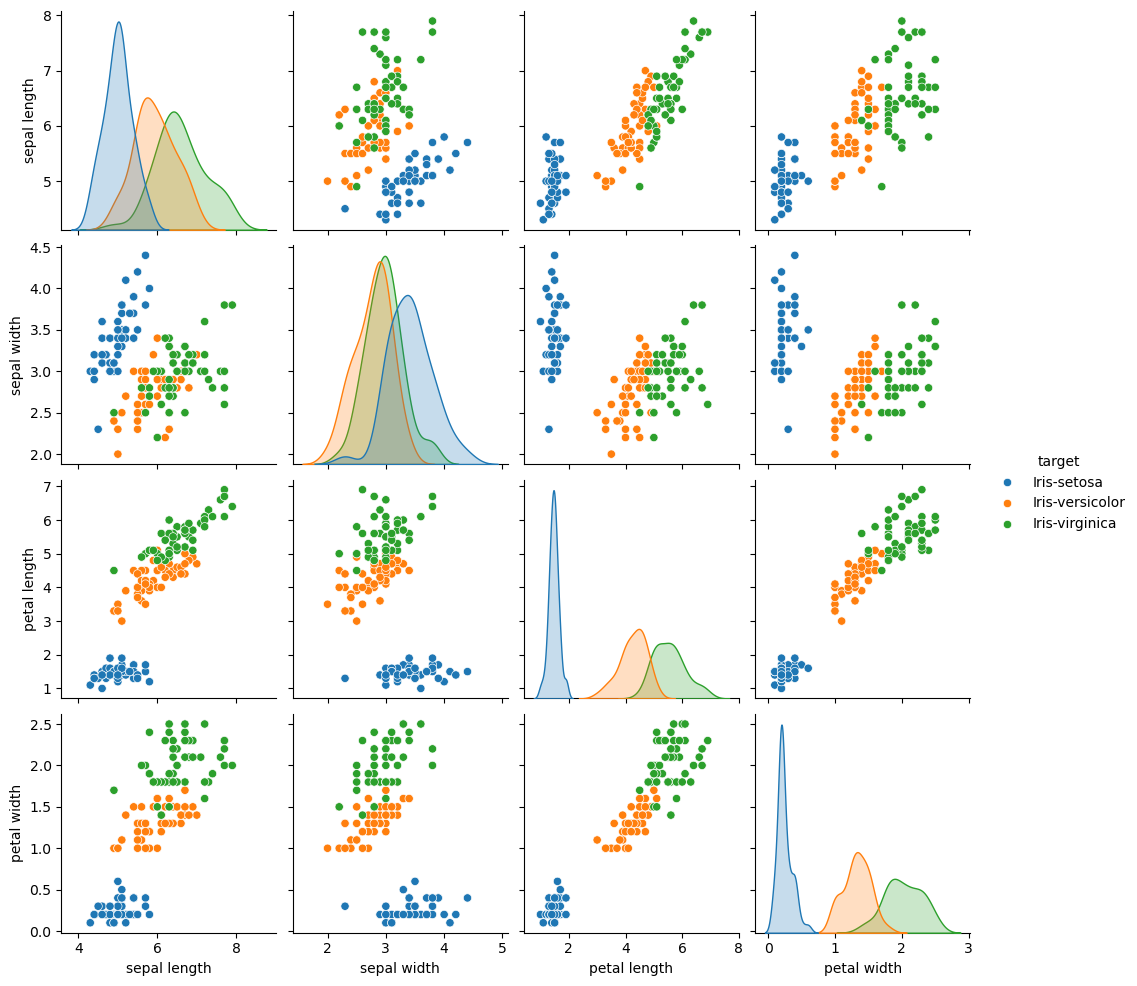

In [15]:
# visualize the raw data
sns.pairplot(data,hue='target')

**Question:** Comment on this data. 

In [16]:
#prepare the data
x = data.iloc[:,0:4]
 
#prepare the target
target = data.iloc[:,4]
 
#Applying it to PCA function
mat_reduced, evals, evecs = PCA(x , 4)
 
#Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2','PC3','PC4'])
 
#Concat it with target variable to create a complete Dataset
principal_df = pd.concat([principal_df , pd.DataFrame(target)] , axis = 1)

<Axes: xlabel='PC1', ylabel='PC2'>

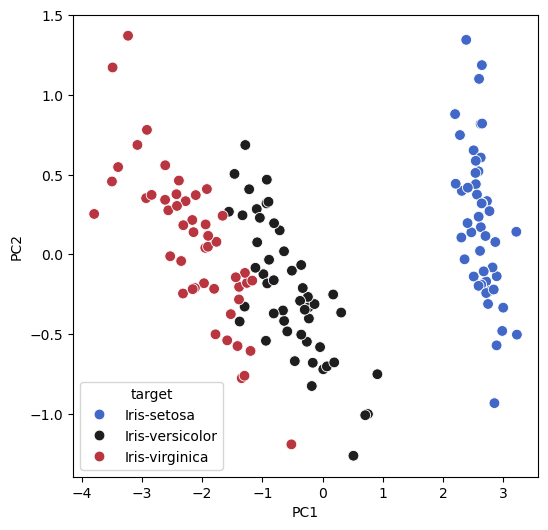

In [17]:
# visualize the PCA reduced data
plt.figure(figsize = (6,6))
sns.scatterplot(data = principal_df , x = 'PC1',y = 'PC2' , hue = 'target' , s = 60 , palette= 'icefire')

**Questions:** 

    1. What do you see in the above figure? 

    2. What has PCA accomplished? 
    
    3. Play with the various PCA components by plotting the different possible pairs of the components in the scatter plot. What happens, say, if you plot component 2 (PC2) vs component 3 (PC3)? 
    
    4. Visualize the eigenvalue spectrum. What does it tell you?

In [18]:
#make the eigenvalue spectrum Here

# PCA with MD simulations

MD simulations create a very high dimensional space where extracting useful or meaningful representations from the noisy and complex dataset can be extremely challenging. The typical dimensions of MD simulations are of the order of $O(10^3$) to $O(10^4)$, giving rise to what is popularly known as [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). PCA is one of the many techniques used to bring the complexity of the simulation space down to a reasonale degree. However, an additional step called [Feature selection](https://en.wikipedia.org/wiki/Feature_selection) is usually performed prior to Dimensionality reduction to get rid of variables which are either of less importance or are removed to distinguish their effect from those that retained. 

In this case, we will be using the previously used MD data set to understand how PCA can help us connect dynamics to function. First, we will start with using only the C-alpha atom coordinates as the Features for dimensionality reduction.

Dowload the data to yoru current directory. This step will take a couple of minutes!

In [19]:
# protein with inhibitor
!curl "https://zenodo.org/record/7303653/files/Sec61_KZR8445_R1.xtc?download=1" --output inhibitor.xtc
!curl "https://zenodo.org/record/7303653/files/Sec61_KZR8445_R1.gro?download=1" --output inhibitor.gro

# protein without inhibitor
!curl "https://zenodo.org/record/7303653/files/Sec61_noinhibitor_R1.xtc?download=1" --output noinhibitor.xtc
!curl "https://zenodo.org/record/7303653/files/Sec61_noinhibitor_R1.gro?download=1" --output noinhibitor.gro

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   273  100   273    0     0    536      0 --:--:-- --:--:-- --:--:--   536
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   273  100   273    0     0   1559      0 --:--:-- --:--:-- --:--:--  1568
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   281  100   281    0     0   1542      0 --:--:-- --:--:-- --:--:--  1535
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   281  100   281    0     0   1393      0 --:--:-- --:--:-- --:--:--  1398


In [20]:
# Run the following on the data downloaded during your earlier practical

# first we write out a reference structure for the analysis 
! echo "3" |gmx trjconv -f noinhibitor.xtc -o ref.pdb -s noinhibitor.gro -dump 0 1>output.dat 2> error.dat

# Now we will write out the CA atoms for the PCA analysis from each trajectory
! echo "3" |gmx trjconv -f noinhibitor.xtc -o ca_noinh.xtc -s noinhibitor.gro 1>output.dat 2> error.dat
! echo "3" |gmx trjconv -f inhibitor.xtc -o ca_inh.xtc -s inhibitor.gro 1>output.dat 2> error.dat

# finally, we fit the data on the reference structure we made in the first step.
! echo "0 0" |gmx trjconv -f ca_noinh.xtc -o fit_noinh.xtc -s ref.pdb -fit rot+trans 1>output.dat 2> error.dat
! echo "0 0" |gmx trjconv -f ca_inh.xtc -o fit_inh.xtc -s ref.pdb -fit rot+trans 1>output.dat 2> error.dat

In [21]:
# MD simulation data
pdb = 'ref.pdb'
trjs = {'No inhibitor':'fit_noinh.xtc','Inhibitor':'fit_inh.xtc'} 

In [22]:
# watch a movie
traj = "fit_inh.xtc"
pdb = "ref.pdb"
model = mda.Universe(pdb,traj )
mda_view = nv.show_mdanalysis(model)
mda_view

/media/kaptan/wrk/opt/miniconda/envs/notebook/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/media/kaptan/wrk/opt/miniconda/envs/notebook/lib/python3.11/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(max_frame=1000)

**Question:** What is happening in this movie? Can your describe how the protein motion affects the inhibitor binding region?

Now, let's try analysing the data with PCA.

In [23]:
# make data for analysis
coords = []
labels = []

for traj in trjs.keys():
    model = mda.Universe(pdb,trjs[traj])
    for frame in model.trajectory:
        coords.append(model.atoms.positions.reshape(-1))
        labels.append(traj)    
coords = np.array(coords)

/media/kaptan/wrk/opt/miniconda/envs/notebook/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/media/kaptan/wrk/opt/miniconda/envs/notebook/lib/python3.11/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [24]:
# We will get the first 10 PCs for analysis.
coords_reduced,evals,_ = PCA(coords,10)

In [25]:
# covert PCA data to a pandas dataframe
df = pd.DataFrame(coords_reduced)
df.insert(loc = len(df.columns), column = 'Sim type', value = labels)

In [26]:
df

0          1          2          3          4          5  \
0      4.227432  17.369449  19.807481 -25.051292  -0.745911 -12.816097   
1     -4.874009  30.477282  28.866370 -25.448473  -3.298114   4.383919   
2     -8.256256  31.899535  34.514598 -13.820367  -2.595242   3.085680   
3     -4.453300  33.643986  29.885902 -18.320197  -6.352632  -3.017818   
4      1.240741  29.399528  34.100063 -21.768381  -0.240815  -6.571427   
...         ...        ...        ...        ...        ...        ...   
1997  49.128969 -14.996350  -7.231158 -18.470177  10.092051   2.313410   
1998  50.401461 -13.937210 -10.315267 -18.540695  13.301571   0.909791   
1999  49.568850 -13.555978  -4.013635 -18.928505  11.177998   2.342421   
2000  52.788456 -14.723903   0.072587 -26.079797  13.347722   5.105476   
2001  51.230750 -11.586847   3.811631 -17.351769  11.494254   0.765342   

              6          7          8          9      Sim type  
0     21.761057 -10.341169 -11.771732   0.477991  No inhibitor  
1     19.704935 -10.521464   1.221842  -6.429171  No inhibitor  
2     19.330847  -9.953050  -3.042046 -10.243162  No inhibitor  
3     13.730326 -13.952695   4.689365 -15.535869  No inhibitor  
4     22.905668 -11.984207   1.350558 -14.143265  No inhibitor  
...         ...        ...        ...        ...           ...  
1997   1.029296   1.200940   0.230165   1.851142     Inhibitor  
1998   0.648982  -2.280231  -5.953515   7.039125     Inhibitor  
1999   0.220931   2.849922  -3.920707   2.873399     Inhibitor  
2000   4.536296   7.292828  -5.252325   5.578430     Inhibitor  
2001   7.685752   1.851251  -8.988968   5.521568     Inhibitor  

[2002 rows x 11 columns]

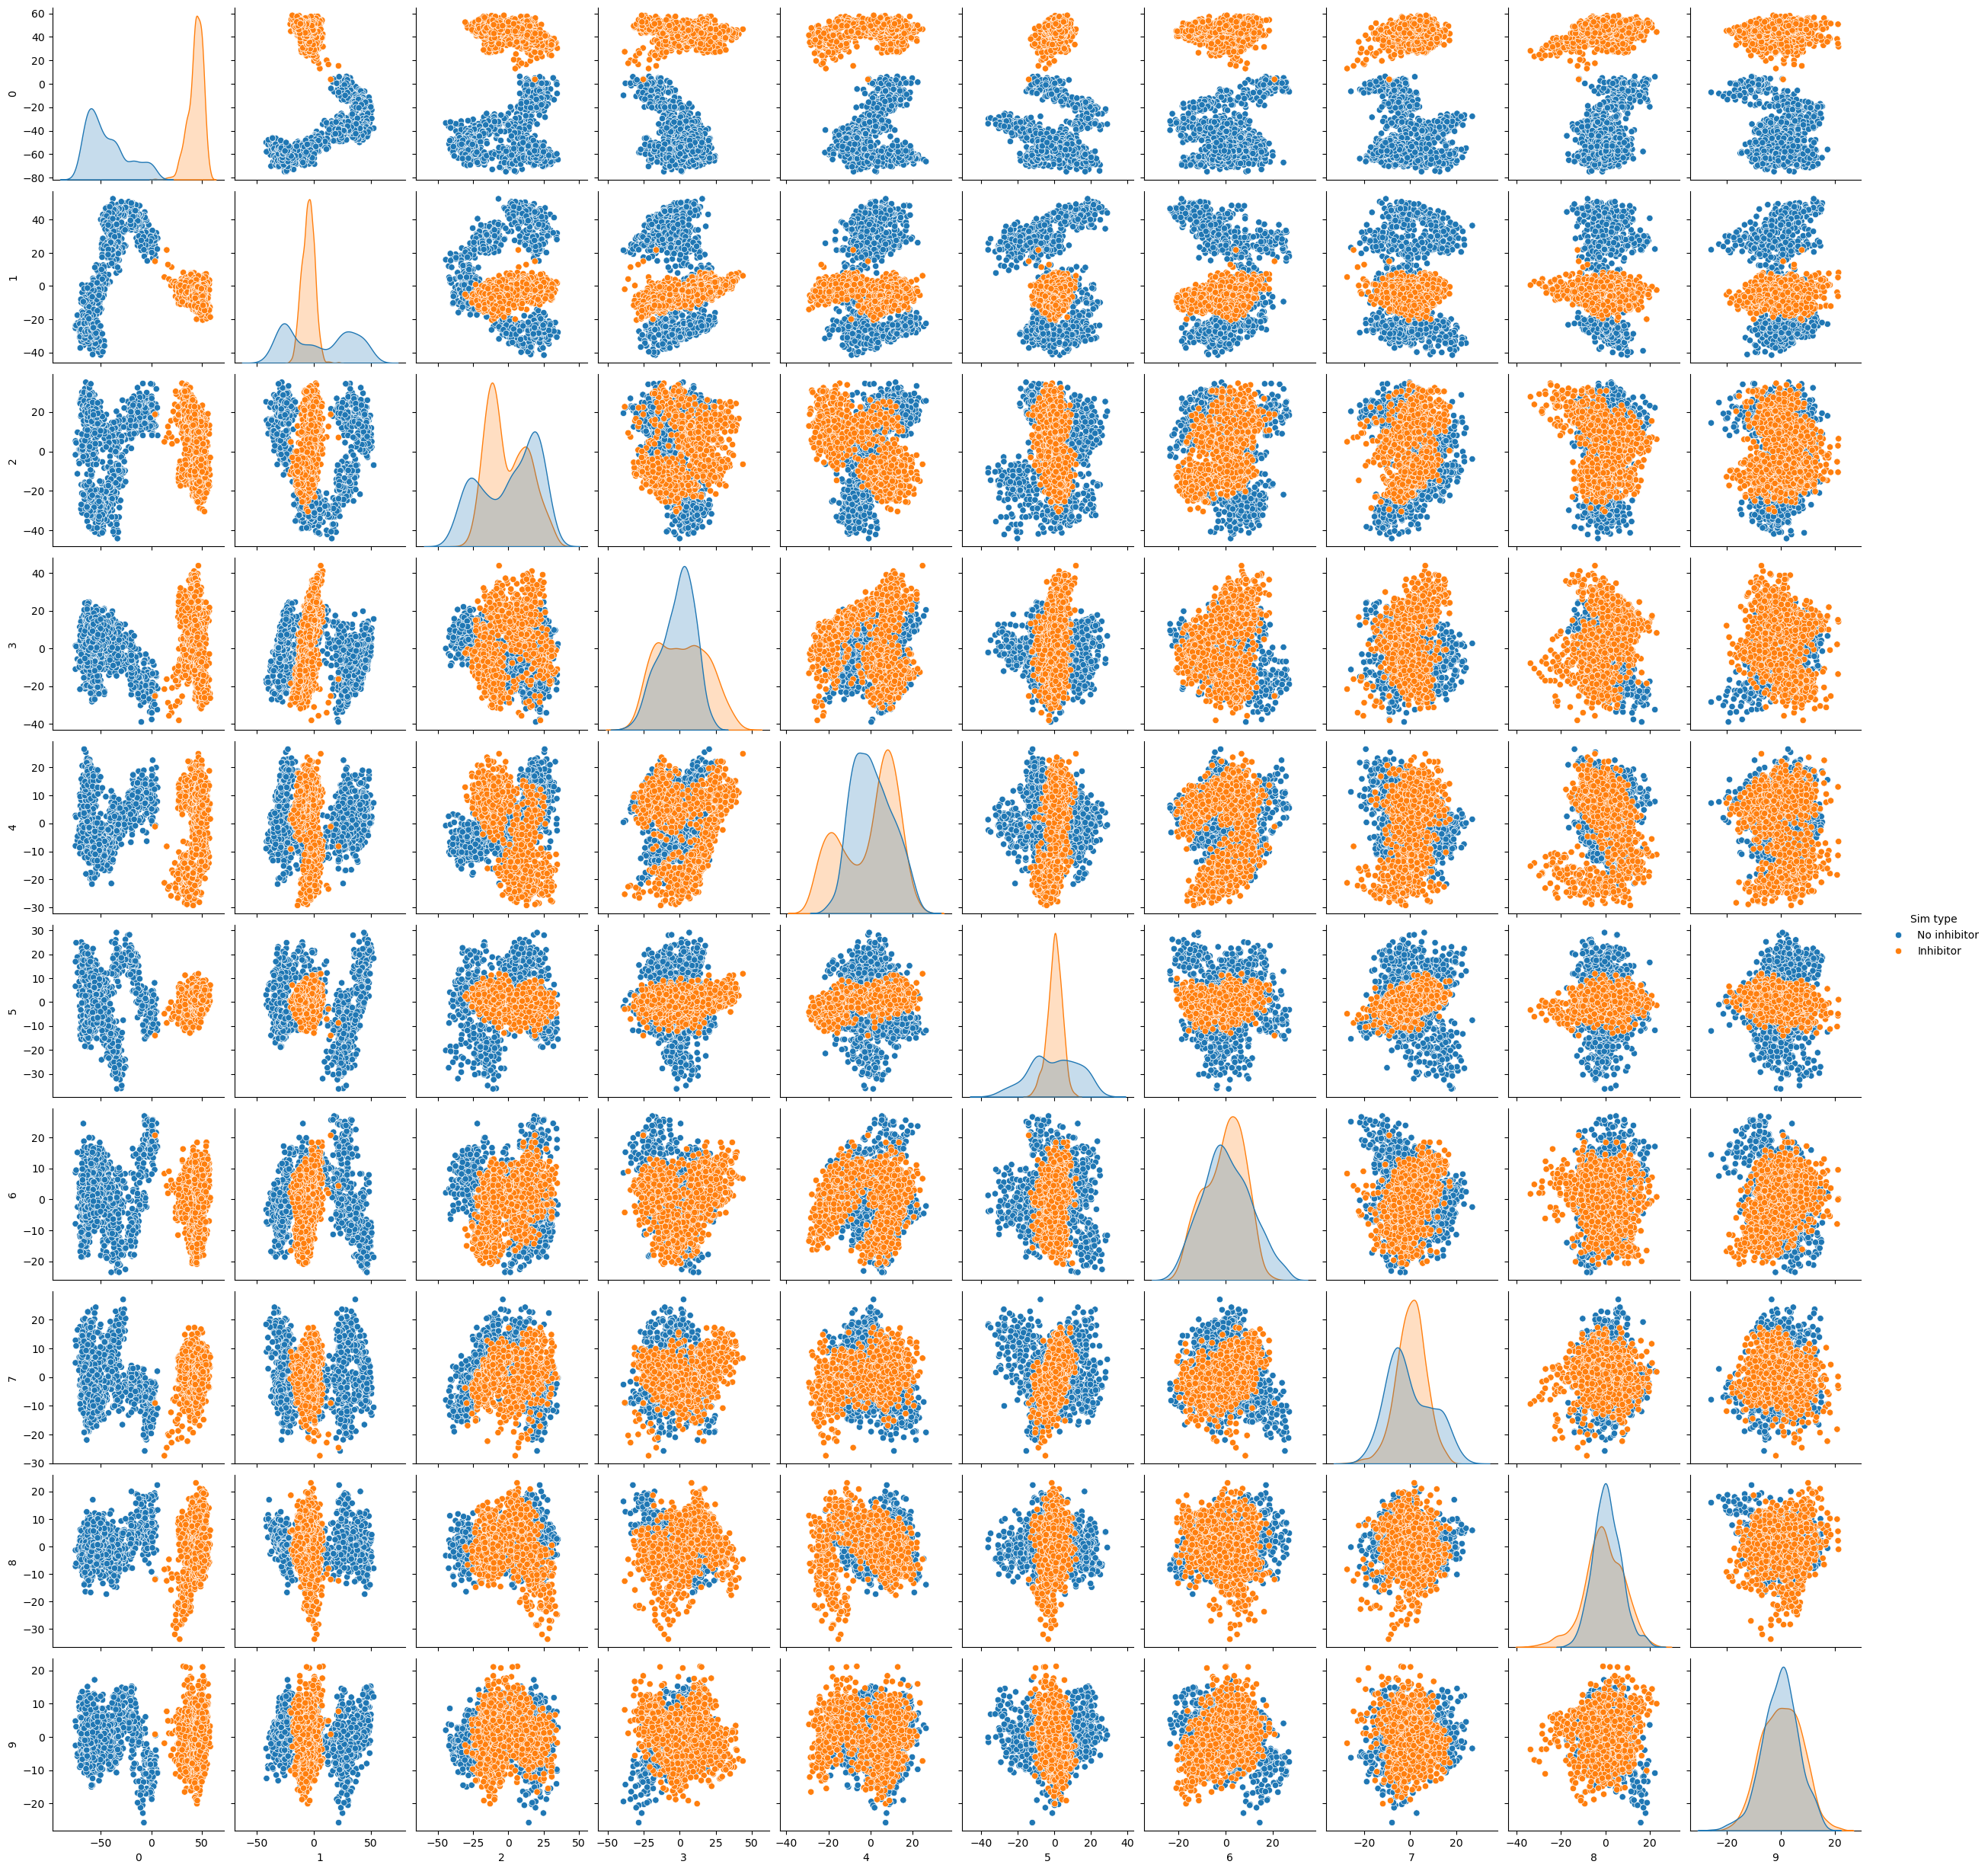

In [27]:
# make pairplot
sns.pairplot(data = df, vars = df.columns[:-1],hue='Sim type')

**Question:** So what do you see in this pairplot? Is there a PC that clearly separates the Inhibitor bound simulations from the one not bound to it?

Now, let's have a look at the so-called "eigenvalue spectrum" of the components of the PCA.

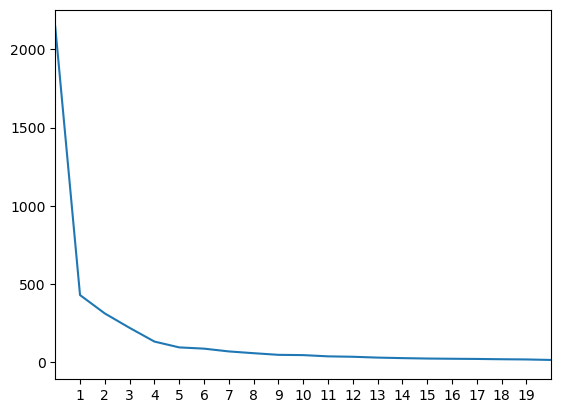

In [28]:
sns.lineplot(evals)
plt.xlim(0,20)
plt.xticks(range(1,20));

You notice that the eigenvalues dramatically drop past the first few components. 

**Question:** Does that give you a hint how many components you should choose for the reduction of dimensionality?

Let's not look at the first component of the PCA. We examine it by projecting the trajectory data along the first component and then *Intrapolating* along this component between the maximum of the projection and the minimum of the projection. 

We will use GMX tools to do so. Please run the following cell to visualize the first component.

In [29]:
# we will first concatinate the two trajectories into a single trajectory 

! gmx concat -cat -f fit_noinh.xtc fit_inh.xtc -o concat.xtc 1>output.dat 2> error.dat

# we will now perform a covariance analysis of the concatinated trajectory to extract the PCA components.
! echo "0 0 " | gmx covar -f concat.xtc -s ref.pdb 1>output.dat 2> error.dat

# We now use the eigenvector analysis (anaeig) tool to visualize the first component
! echo "0 0" | gmx anaeig -f concat.xtc -v eigenvec.trr -s ref.pdb -first 1 -last 1 -extr extr1.xtc -nframes 20 1>output.dat 2> error.dat

In [30]:
# watch a movie corresponding to the first PC
traj = "extr1.xtc"
pdb = "ref.pdb"
model = mda.Universe(pdb,traj )
mda_view = nv.show_mdanalysis(model)
mda_view

/media/kaptan/wrk/opt/miniconda/envs/notebook/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "
/media/kaptan/wrk/opt/miniconda/envs/notebook/lib/python3.11/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


NGLWidget(max_frame=19)

**Question:** What does the first component show? Which parts of the protein are the motions in the first component localized? How does this movie compare to the raw data we saw earlier?

**Question:** Try visualizing other components. Are they different from the first component? If so, in what way? 

**Question:** Are the PCA components more or less noisy than the raw trajectories seen earlier? In your words try to explain why it is so.

# Questions

1. Show that the PCA components from the concatinated trajectories are orthogonal to each other.

2. How can you create a model using the anaeig tool that contains the combined effect of the first N components? Visualize a combined model made from first two PCA components using the code above.
